In [87]:
import copy
import random
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)    
matplotlib.rcParams['axes.unicode_minus'] = False      
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 150)

from xgboost import XGBRegressor

import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
torch.set_printoptions(sci_mode=False)
random_seed = 616

### 기본 데이터

In [4]:
y_col = '유입량'
PK_col = ['홍수사상번호','연','월','일','시간']

In [23]:
data_raw = pd.read_excel('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210803.xlsx', header=[0,1])

data_raw.columns = ['_'.join(col).strip() if "Unnamed" not in col[1] else col[0] for col in data_raw.columns.values]
test_idx = data_raw[data_raw.isna().any(axis=1)].index

In [24]:
# 결과 값 저장할 dataframe 생성

predict_df = pd.DataFrame()
predict_df[PK_col] = data_raw[PK_col]
predict_df['true'] = data_raw.유입량

score_df = pd.DataFrame()

## source code

In [25]:
class DNN(nn.Module):
    def __init__(self, input_size, hidden_layer=(1, 1, 1), batch_norm=True, drop_out=True, drop_prob=0.3):
        super().__init__()
        self.hidden_layer = self.make_layers(input_size, hidden_layer, batch_norm, drop_out, drop_prob)

    def forward(self, x):
        out = self.hidden_layer(x)
        return out

    def make_layers(self, input_size, hidden_layer, batch_norm, drop_out, drop_prob):
        layers = []
        in_size = input_size
        if hidden_layer[0] == 'R':
            for v in hidden_layer[1:]:
                out_size = int(v)
                linear = nn.Linear(in_size, out_size)
                torch.nn.init.xavier_uniform_(linear.weight)
                layers += [linear]

                if batch_norm:
                    layers += [nn.BatchNorm1d(out_size)]

                if drop_out:
                    layers += [torch.nn.Dropout(p=drop_prob)]

                layers += [nn.ReLU(inplace=True)]

                in_size = out_size
        else:
            for v in hidden_layer:
                out_size = int(input_size * v)
                linear = nn.Linear(in_size, out_size)
                torch.nn.init.xavier_uniform_(linear.weight)
                layers += [linear]

                if batch_norm:
                    layers += [nn.BatchNorm1d(out_size)]

                if drop_out:
                    layers += [torch.nn.Dropout(p=drop_prob)]

                layers += [nn.ReLU(inplace=True)]

                in_size = out_size

        linear = nn.Linear(out_size, 1)
        torch.nn.init.xavier_uniform_(linear.weight)
        layers += [linear]

        return nn.Sequential(*layers)

In [26]:
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

In [27]:
first_values = data_raw.groupby('홍수사상번호').first()['유입량']

def dnn_predict(name, data, model_structure, scaler, view=False, view_num=5, early_stop_num = 3):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device
    pred_values = []
    predict_df = pd.DataFrame()
    predict_df[PK_col] = data[['홍수사상번호','연','월','일','시간']]
    predict_df['true'] = data.유입량
    
    for num in data.홍수사상번호.unique():
        print(f"홍수사상번호 {num} 시작")
        train = data[data['홍수사상번호'] != num].dropna().copy()
        valid = data[data['홍수사상번호'] == num].copy()

        X_train = train.drop(columns=[y_col]+PK_col)
        y_train = train[y_col]

        X_valid = valid.drop(columns=[y_col]+PK_col)
        y_valid = valid[y_col]
        
        scaler.fit(X_train)

        X_train_tensors = torch.Tensor(scaler.transform(X_train)).to(device)
        X_valid_tensors = torch.Tensor(scaler.transform(X_valid)).to(device)

        y_train_tensors = torch.Tensor(y_train.values).to(device)
        y_valid_tensors = torch.Tensor(y_valid.values).to(device)
        
        input_size = X_train.shape[1]

        dnn = DNN(input_size, model_structure["hidden_layer"], model_structure["batch_norm"],
                  model_structure["drop_out"], model_structure["drop_prob"]).to(device)
        criterion = torch.nn.MSELoss()    # mean-squared error for regression
        optimizer = torch.optim.Adam(dnn.parameters(), lr=model_structure["learning_rate"])  # adam optimizer
        
        best_loss = 1E+10
        best_epoch = 0
        for epoch in range(model_structure["num_epochs"]):
            optimizer.zero_grad()
            outputs = dnn(X_train_tensors)
            loss = criterion(outputs.view(-1), y_train_tensors.view(-1))
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                dnn.eval()
                outputs_valid = dnn(X_valid_tensors)
                loss_valid = criterion(outputs_valid.view(-1), y_valid_tensors.view(-1))
                if loss_valid < best_loss:
                    best_loss = loss_valid
                    best_epoch = epoch
                    pred_valid = list(outputs_valid.view(-1).detach().cpu().numpy())
                dnn.train()

            if view and ((epoch+1) % (model_structure["num_epochs"]//view_num) == 0):
                print("  Epoch: %d, Train Loss: %1.2f Best Epoch: %d Best Valid Loss: %1.2f" % (epoch+1, loss.item(), best_epoch+1, best_loss.item()))
            
            if (epoch - best_epoch) > (model_structure["num_epochs"] // early_stop_num):
                print("Best Epoch: %d Best Valid Loss: %1.2f" % (best_epoch+1, best_loss.item()))
                break
        print("")
        pred_values += pred_valid
    
    predict_df[f'pred_DNN_{name}'] = pred_values
    
    return predict_df

In [28]:
def fill_nan(predict_df):
    for num in predict_df.홍수사상번호:
        predict_num = predict_df[predict_df.홍수사상번호 == num]
        predict_num = predict_num.fillna(method='ffill').fillna(method='bfill')
        predict_df.loc[predict_df.홍수사상번호 == num] = predict_num
        
def rmse(predict_df, name):
    pred = predict_df[predict_df[f'pred_DNN_{name}'].notnull()][f'pred_DNN_{name}']
    true = predict_df.loc[pred.index]['true']
    return np.sqrt(mean_squared_error(true, pred))

def rmsle(predict_df, name):
    pred = predict_df[predict_df[f'pred_DNN_{name}'].notnull()][f'pred_DNN_{name}']
    true = predict_df.loc[pred.index]['true']
    return np.sqrt(mean_squared_log_error(true, pred))
    
def r2(predict_df, name):
    pred = predict_df[predict_df[f'pred_DNN_{name}'].notnull()][f'pred_DNN_{name}']
    true = predict_df.loc[pred.index]['true']
    return r2_score(true, pred)

def mape(predict_df, name):
    pred = predict_df[predict_df[f'pred_DNN_{name}'].notnull()][f'pred_DNN_{name}']
    true = predict_df.loc[pred.index]['true']
    return np.mean(np.abs((true - pred) / true))*100

## model structure

In [65]:
model_structure = {
    "num_epochs" : 100000,
    "learning_rate" : 0.01,
    "hidden_layer" : (1,1),
    "batch_norm" : 1,
    "drop_out" : 1,
    "drop_prob" : 0.5
}

In [66]:
n = 5
name = f't + x2'

data_t_x2 = data_raw.copy()

x2_col = data_t_x2.filter(regex="수위\(E지역\)").columns
for col in x2_col:
    data_t_x2[col + '_x2'] = data_t_x2[col] ** 2

for col in data_t_x2.columns.difference([y_col] + PK_col):
    data_t_x2[f'{col}_shift 1'] = data_t_x2[col].shift()
    data_t_x2[f'{col}_shift1 -1'] = data_t_x2[col].shift(-1)

shift_col = data_t_x2.filter(regex='shift').columns
data_t_x2['홍수사상번호_shift 1'] = data_t_x2['홍수사상번호'].shift()
data_t_x2['홍수사상번호_shift -1'] = data_t_x2['홍수사상번호'].shift(-1)

data_t_x2.loc[(data_t_x2['홍수사상번호'] != data_t_x2['홍수사상번호_shift 1']), shift_col] = np.nan
data_t_x2.loc[(data_t_x2['홍수사상번호'] != data_t_x2['홍수사상번호_shift -1']), shift_col] = np.nan

train_data = data_t_x2.dropna()
test_data = data_t_x2.loc[test_idx]

In [67]:
view_num = 10

In [68]:
scaler = RobustScaler()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device

X_train = train_data.drop(columns=[y_col]+PK_col)
y_train = train_data[y_col]

X_test = test_data.drop(columns=[y_col]+PK_col)
y_test = test_data[y_col]

scaler.fit(X_train)

X_train_tensors = torch.Tensor(scaler.transform(X_train)).to(device)
y_train_tensors = torch.Tensor(y_train.values).to(device)

X_test_tensors = torch.Tensor(scaler.transform(X_test)).to(device)
y_test_tensors = torch.Tensor(y_test.values).to(device)

input_size = X_train.shape[1]

dnn = DNN(input_size, model_structure["hidden_layer"], model_structure["batch_norm"],
          model_structure["drop_out"], model_structure["drop_prob"]).to(device)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(dnn.parameters(), lr=model_structure["learning_rate"])  # adam optimizer

best_loss = 1E+10
best_epoch = 0
for epoch in range(model_structure["num_epochs"]):
    optimizer.zero_grad()
    outputs = dnn(X_train_tensors)
    loss = criterion(outputs.view(-1), y_train_tensors.view(-1))
    loss.backward()
    optimizer.step()
    
    if ((epoch+1) % (model_structure["num_epochs"]//view_num) == 0):
        print("Epoch: %d, Train Loss: %1.2f" % (epoch+1, loss.item()))

Epoch: 10000, Train Loss: 130222.99
Epoch: 20000, Train Loss: 135829.73
Epoch: 30000, Train Loss: 133456.11
Epoch: 40000, Train Loss: 118086.65
Epoch: 50000, Train Loss: 122619.99
Epoch: 60000, Train Loss: 100575.56
Epoch: 70000, Train Loss: 118198.41
Epoch: 80000, Train Loss: 116504.24
Epoch: 90000, Train Loss: 96543.33
Epoch: 100000, Train Loss: 104498.70


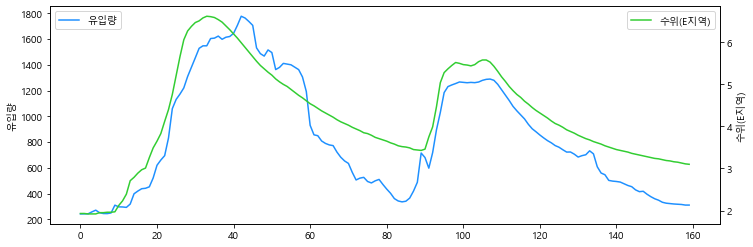

In [118]:
with torch.no_grad():
    dnn.eval()
    pred_test = dnn(X_test_tensors).view(-1).detach().cpu().numpy()
    pred_test[0] = pred_test[1]
    pred_test[-1] = pred_test[-2]
    dnn.train()
    

fig, ax1 = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(12)

ax1.plot(pred_test,color='dodgerblue', label='유입량')
ax2 = ax1.twinx()
ax2.plot(test_data['데이터집단 1_수위(E지역)'].values,color='limegreen', label='수위(E지역)')
ax1.set_ylabel('유입량')
ax2.set_ylabel('수위(E지역)')
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

In [81]:
test_df = pd.read_excel('data/02_평가데이터/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_평가데이터_210803.xlsx')
test_df.loc[1:,'유입량'] = pred_test
test_df = test_df.loc[1:]

In [119]:
test_df.to_csv('data/02_평가데이터/predict_test.csv')